# Sparkify Churn Prediction

After the data has been explored, preprocessed (e.g. by removing records from unknown users), and visualized in `run_exploratory_data_analysis.ipynb`, this notebook contains a feature engineering and churn prediction approach. Please note that setting up the PySpark cluster in the cloud and building the ML pipeline was the focus of the project. Feature engineering was done rather quick and definitely leaves potential for improving  the results.

Please note that we will not work with the original Sparkify dataset (12GB) in this project but a medium-sizes subset (462MB). This is because I wanted to implement the Sparkify pipeline on Google Cloud Platform (GCP). The original dataset is stored on Amazon's S3 though and the way it is configured does not allow to easily transfer it to GCP. If so, the pipeline could easily be scaled up and re-executed with the original dataset.

## Requirements

1. The notebook must be executed from GCP so it can access Cloud Storage.
2. The notebook must be executed from a PySpark kernel.

## Content

This notebook contains the following steps:

1. [Load & Preprocess Data](#load-data)
2. [Feature Engineering](#feature-engineering)
3. [Machine Learning Pipeline](#pipeline)
4. [Conclusion](#conclusion)

In [1]:
project_dir = "/home/Sparkify-churn"
bucket_name = "pyspark-cluster-202205"
file_path = "data/medium_sparkify_event_data.json"

## Import Packages

In [2]:
import time
import numpy as np

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import udf 
from pyspark.sql.types import FloatType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, NaiveBayes
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler, Normalizer, MinMaxScaler, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

import os
os.chdir(project_dir)
from preprocessing_sparkify import preprocess_sparkify_data

%matplotlib inline

## 1. Load & Preprocess Data<a name="load-data"></a>

The preprocessing steps have been explored in `run_exploratory_data_analysis.ipynb` and the code has been saved to `preprocessing_sparkify.py`.

In detail, preprocessing contains:
1. Removal of records with missing values in the columns `sessionId` and `userId`
2. Creation of a binary column `churn` for every record (1 if `page` = `Cancellation Confirmation`, 0 otherwise)
3. Creation of binary column `gender` for every user (0 if `gender` = "F", 1 if `gender` = "M")
4. Creation of columns `date` and `weekday` from the timestamp of an event stored in column `ts`

In [3]:
df = spark.read.json(f"gs://{bucket_name}/{file_path}")

In [4]:
df = preprocess_sparkify_data(df)

## 2. Feature Engineering<a name="feature-engineering"></a>

In [5]:
df.createOrReplaceTempView("sparkify")

In [6]:
df_model = spark.sql("""
    with sparkify_agged as (
        select
            userId as user_id,
            max(churn) as has_churned,
            min(date) as min_date,
            max(date) as max_date,
            datediff(date_add(max(date), 1), min(date)) as days_active,
            count(distinct sessionId) as sessions,
            count(sessionId) as interactions,
            max(case when gender = 'M' then 1 when gender = 'F' then 0 end) as gender,
            sum(case when method = 'PUT' then 1 else 0 end) / count(method) as activity_factor
        from sparkify
        group by userId
    )
    select
        user_id,
        gender,
        sessions,
        sessions / days_active as sessions_per_day,
        interactions,
        interactions / days_active as interactions_per_day,
        activity_factor,
        has_churned as label
    from sparkify_agged
""")
df_model.show(40)

+-------+------+--------+-------------------+------------+--------------------+------------------+-----+
|user_id|gender|sessions|   sessions_per_day|interactions|interactions_per_day|   activity_factor|label|
+-------+------+--------+-------------------+------------+--------------------+------------------+-----+
| 100010|     0|       2|                0.5|         274|                68.5|0.7956204379562044|    1|
| 200002|     1|       5|0.16666666666666666|         790|  26.333333333333332|0.8886075949367088|    1|
|    296|     0|       5| 0.5555555555555556|         304|   33.77777777777778|0.8552631578947368|    1|
|    125|     1|       3|0.06666666666666667|         168|  3.7333333333333334|0.8452380952380952|    0|
|    124|     0|      17|0.40476190476190477|        4312|  102.66666666666667|0.9438775510204082|    1|
|     51|     1|       5|             0.3125|         656|                41.0|0.9176829268292683|    1|
|      7|     1|      15|0.25862068965517243|        12

In [7]:
df_model.count()

448

## 3. Machine Learning Pipeline<a name="pipeline"></a>

The ML pipeline contains the following steps:

3.1 Train Test Split<br>
3.2 Definition of Transformers and Estimators<br>
3.3 Creation of ML Pipeline<br>
3.4 Model Training using Cross-Validation<br>
3.5 Model Evaluation<br>

, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### 3.1 Train Test Split

The input data will be randomly split into 80% for training and 20% for testing the model. Since cross-validation will be run on the training, there is no need to create a validation set.

In [8]:
# split data into training and test set
train, test = df_model.randomSplit([0.8, 0.2], seed=42)

In [9]:
train.count(), test.count()

(362, 86)

### 3.2 Definition of Transformers and Estimators

For an ML task, numeric features should be scaled or normalized to make sure they are in the same range. Otherwise, some features could dominate the results. There are multiple ways to achieve this in PySpark: Normalizer, StandardScaler or MinMaxScaler. Here, I will use the Normalizer. In PySpark, all these functions require vectors as an input. This is why VectorAssembler has to be applied first.

In [10]:
features = df_model.columns[1:-1]

In [11]:
# transformers
assembler = VectorAssembler(inputCols=features, outputCol="feature_vector")  # put features into a vector
scaler = Normalizer(inputCol="feature_vector", outputCol="features")  # normalize features

In this and many other contexts, churn prediction is a binary classification task. PySpark's ML library offers multiple learning algorithms for classification. After having run first tests, Random Forest Classifiers and Gradient-Boosted Trees turned out to outperform Logistic Regression. This is why the focus will be on these two learning algorithms in this project.

In [12]:
# estimators
rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)
gbt = GBTClassifier(featuresCol="features", labelCol="label", seed=42)

### 3.3 Creation of ML Pipeline

When it comes to creating the ML pipeline, PySpark's Pipeline and ParamGridBuilder objects come in handy. Pipeline allows to put stages of the model together. ParamGridBuilder allows to test multiple models with different parameters.

In [13]:
# initialize an empty pipeline
pipeline = Pipeline(stages=[])

In [14]:
# create a ParamGridBuilder to construct a grid of parameters to search over
param_grid_rf = (
    ParamGridBuilder()
    .baseOn({pipeline.stages: [assembler, scaler, rf]})
    .addGrid(rf.numTrees, [10, 20, 30])
    .addGrid(rf.featureSubsetStrategy, ["onethird", "sqrt"])  # number of features to consider for splits at each tree node
    .build()
)

param_grid_gbt = (
    ParamGridBuilder()
    .baseOn({pipeline.stages: [assembler, scaler, gbt]})
    .addGrid(gbt.maxDepth, [5, 10, 15])
    .addGrid(gbt.featureSubsetStrategy, ["onethird", "sqrt"])  # number of features to consider for splits at each tree node
    .build()
)

param_grids = param_grid_rf + param_grid_gbt

### 3.4 Model Training using Cross-Validation

The most common ways to evaluate a classification task are Accuracy, Precision, Recall and F1 Score. In this project, the performance will be optimized with respect to the F1 Score since the churned users are a fairly small subset. The pipeline and the parameter grids run together in PySpark's CrossValidator object, which runs 5-fold cross-validation while training the different models and evaluates which respect to the desired metric, here F1 Score.

In [15]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="f1")

In [16]:
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=param_grids,
    evaluator=evaluator,
    numFolds=5,  # use 3+ folds in practice
    parallelism=4,
)

In [ ]:
start_time = time.time()
cv_model = crossval.fit(train)
end_time = time.time()

print(f"--- Execution time: {round(end_time-start_time, 2)} seconds ---")

--- Execution time: 9638.14 seconds ---


### 3.5 Model Evaluation

In [18]:
cv_model.avgMetrics

[0.8382899549962829,
 0.8308256086540726,
 0.8389025463551323,
 0.8421254610363267,
 0.842621234151868,
 0.8321941628971747,
 0.8091890612799251,
 0.7889585496670775,
 0.8063956501232179,
 0.7657218011664128,
 0.798456238378688,
 0.7626007853714708]

#### Summary of all trained models

In [19]:
# generate column names for results table
num_params = len(cv_model.getEstimatorParamMaps()[0])
columns = [f"param_{i+1}" for i in range(num_params)] + ["metric"]

In [20]:
# extract values for results table
values = []
cv_params = list(cv_model.getEstimatorParamMaps())
for idx_1, model in enumerate(cv_params):
    
    # create a list with key value pairs for every parameter
    model_values = []
    for items in list(model.items()):        
        param = items[0].name
        value = items[1]
        if isinstance(value, list):
            value = [str(v).split("_")[0] for v in value]  # remove suffix from e.g. "VectorAssembler_3fddb46bbd9e"
        model_value = {param: value}
        model_values.append(str(model_value))
        
    # add metric to list
    metric = cv_model.avgMetrics[idx_1]
    model_values.append(round(metric, 2))
    
    values.append(model_values)

In [21]:
df_results = spark.createDataFrame(values, columns)
df_results.orderBy("metric", ascending=False).show(truncate=False)

+-----------------------------------------------------------------------+----------------+-------------------------------------+------+
|param_1                                                                |param_2         |param_3                              |metric|
+-----------------------------------------------------------------------+----------------+-------------------------------------+------+
|{'stages': ['VectorAssembler', 'Normalizer', 'RandomForestClassifier']}|{'numTrees': 30}|{'featureSubsetStrategy': 'onethird'}|0.84  |
|{'stages': ['VectorAssembler', 'Normalizer', 'RandomForestClassifier']}|{'numTrees': 10}|{'featureSubsetStrategy': 'onethird'}|0.84  |
|{'stages': ['VectorAssembler', 'Normalizer', 'RandomForestClassifier']}|{'numTrees': 20}|{'featureSubsetStrategy': 'onethird'}|0.84  |
|{'stages': ['VectorAssembler', 'Normalizer', 'RandomForestClassifier']}|{'numTrees': 20}|{'featureSubsetStrategy': 'sqrt'}    |0.84  |
|{'stages': ['VectorAssembler', 'Normalizer', 'R

#### Worst model

The worst model is a Gradient-Boosted Tree with `maxDepth = 15` and `featureSubsetStrategy = "sqrt"`.

In [22]:
cv_model.avgMetrics[np.argmin(cv_model.avgMetrics)]

0.7626007853714708

In [23]:
cv_model.getEstimatorParamMaps()[np.argmin(cv_model.avgMetrics)]

{Param(parent='Pipeline_60fff49b6bdc', name='stages', doc='a list of pipeline stages'): [VectorAssembler_fbe6f3169f33,
  Normalizer_37e70c827daa,
  GBTClassifier_bc4c9b8f0032],
 Param(parent='GBTClassifier_bc4c9b8f0032', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 15,
 Param(parent='GBTClassifier_bc4c9b8f0032', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto'"): 'sqrt'}

#### Best model

The best model is a Random Forest with `numTrees = 30` and `featureSubsetStrategy = "onethird"`.

In [24]:
cv_model.avgMetrics[np.argmax(cv_model.avgMetrics)]

0.842621234151868

In [25]:
cv_model.getEstimatorParamMaps()[np.argmax(cv_model.avgMetrics)]

{Param(parent='Pipeline_60fff49b6bdc', name='stages', doc='a list of pipeline stages'): [VectorAssembler_fbe6f3169f33,
  Normalizer_37e70c827daa,
  RandomForestClassifier_8fd1f0b4f8a1],
 Param(parent='RandomForestClassifier_8fd1f0b4f8a1', name='numTrees', doc='Number of trees to train (>= 1).'): 30,
 Param(parent='RandomForestClassifier_8fd1f0b4f8a1', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto'"): 'onethird'}

In [26]:
feature_imp = [i for i in cv_model.bestModel.stages[2].featureImportances]

In [27]:
df_feature_imp = (
    spark
    .createDataFrame(
        [(str(elem[0]), float(elem[1])) for elem in zip(features, feature_imp)],
        schema=["feature", "feature_importance"]
    )
    .toPandas()
)

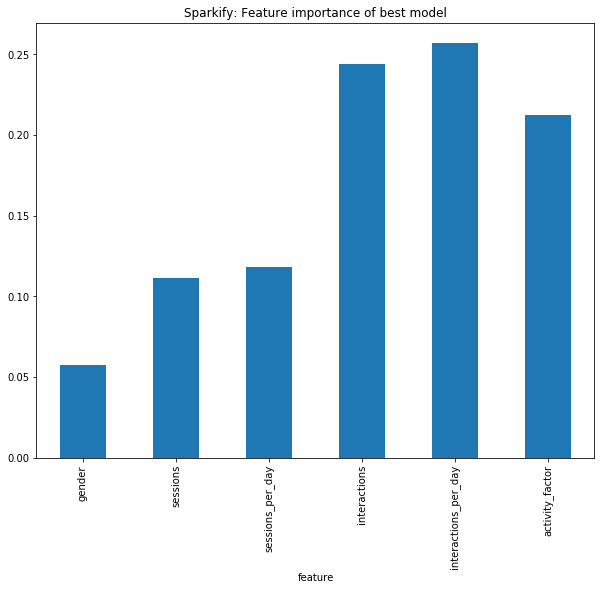

In [28]:
df_feature_imp.plot(
    x="feature",
    y="feature_importance",
    kind="bar",
    figsize=(10,8),
    title="Sparkify: Feature importance of best model",
    legend=False,
    color="#1f77b4",
);

#### Predict new data using the best model

PySpark will automatically select the best model for making predictions.

In [29]:
prediction = cv_model.transform(test)

In [30]:
# F1 score
f1_score = evaluator.evaluate(prediction)
f1_score

0.9171083258121213

In [31]:
prediction = prediction.withColumn("label", F.col("label").cast(FloatType()))
preds_and_labels = prediction.select("prediction", "label").orderBy("prediction")
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix

array([[71.,  3.],
       [ 4.,  8.]])

### Results

- The data was randomly split into a training set with 362 users and a test set with 86 users.
- The training set was used to train 12 different models (6 Gradient-Boosted Trees & 6 Random Forests).
- Using 5-fold cross-validation, the performance of each of the models was evaluated during training.
- It took the pipeline 9,638 seconds or a bit more than 2.5 hours to train the different models.
- **Best model:** With an F1 Score of 0.842, the Random Forest with 30 trees and the feature subset strategy "onethird" was the best model for predicting churn during cross-validation.
- The feature importance chart below provides additional insights:

1. The number of interactions a user has made (`interactions`), the interactions a user has made per day (`interactions_per_day`), and the activity factor which is the share of interactions with a PUT method (`activity_factor`) are most important for predicting churn.
2. On the other hand, the gender is the least important for churn prediction.
3. In other words, how often somebody uses the Sparkify service an how actively somebody uses the Sparkify service are the factors that are mostly influencing whether a user is likely to churn.

- On the test set, the best Random Forest achieved an F1 Score of 0.876.
- The gap between the training set score 0.844 and the test set score 0.876, shows that there is no under- or overfitting of the data.
- The better performance on the test set is expected to be due to the relatively small sample size. Usually, a prediction does not perform better on the test set but this effect is most likely because of the small sample size and will balance with more data.

## 4. Conclusion<a name="conclusion"></a>

### Reflection

The project covered a realistic end-to-end project: from receiving an unknown dataset to coming up with predictions that can be used for steering business decisions. The data was provided in a quite structured and cleaned way. Data exploration has shown that some preprocessing and cleaning steps were still required though. After having created the features for making predictions, 12 models were tested using 5-fold cross-validation and grid-search. Finally, the best model was evaluated and investigated more detailed.

Interestingly, the process was quite straightforward in this project. In practice, there will be much more complexity and iteration in such a process most of the time. This is because multiple stakeholders will be involved and the project will cover even more aspects, e.g. data preparation, presentation of results, implementation of the model.

The learning algorithm which is quite simple predicted that 11 of the 86 user are likely to churn. 8 of those 11 customers turned out to actually have churned. Using more data, more sophisticated features and different learning algorithms, the performance might get even better. In a real-world setting, Sparkify could have invested into trying to prevent these 11 customers from churning.

### Improvement

Finally, this section summarizes thoughts about further improvement:

1. Improve the feature engineering process
    - The features of the ML model in this project were quite intuitive and simple and there is for sure room to improve this.
    - Ideas:
        - Dive deeper into feature importance of the trained models to learn about what helps the model in identifying patterns and what doesn't.
        - Add more creativity/ideas/experience to the task by discussing in a team.
2. Wrap the preprocessing steps into the Pipeline to keep all steps together
3. Try more learning algorithms
4. Try different parameter grids
5. Automate the pipeline to make it run on a regular basis
    - In practice, this task may be recurrent (obviously after it has been A/B tested and approved).
    - Code should be organized in `.py` files to make its execution easier.
    - The pipeline should run automatically on a regular basis.